In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
augmented_icm_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/GT_ICM'
augmented_images_dir = '/content/drive/MyDrive/pfa-augmented-dataset1/Images'     #donc just chitbadlo il path lil masks ken chni5dmo il zp wala te

images = []
icm_masks = []
SIZE = 256

file_names = os.listdir(augmented_images_dir)

for file_name in file_names:
    image_path = os.path.join(augmented_images_dir, file_name)
    icm_mask_path = os.path.join(augmented_icm_dir, file_name.replace('.png', ' ICM_Mask.png'))

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    icm_mask = cv2.imread(icm_mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, (SIZE, SIZE))
    icm_mask = cv2.resize(icm_mask, (SIZE, SIZE))

    image = np.expand_dims(image, axis=-1) / 255.0
    icm_mask = np.expand_dims(icm_mask, axis=-1) / 255.0

    images.append(image)
    icm_masks.append(icm_mask)

images = np.array(images)
icm_masks = np.array(icm_masks)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, icm_masks, test_size=0.2, random_state=42)

In [4]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_metric(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [5]:
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

In [6]:
#il block hatha mta3 il unet baseline

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
weight_decay=1e-8
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [7]:
input_shape = X_train.shape[1:]
modelicm = build_unet(input_shape)
modelicm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [8]:
#hathom il callbacks il chicontroliw il training mta3na
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau( patience=5,factor=0.5, verbose=1,min_lr=1e-6),
]

In [ ]:
history = modelicm.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
)

Epoch 1/200


Exception ignored in: <function _xla_gc_callback at 0x7991719863e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - dice_metric: 0.1494 - iou_metric: 0.0905 - loss: 0.8506 - val_dice_metric: 0.1399 - val_iou_metric: 0.0511 - val_loss: 0.8588 - learning_rate: 1.0000e-04
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - dice_metric: 0.1867 - iou_metric: 0.1236 - loss: 0.8133 - val_dice_metric: 0.1366 - val_iou_metric: 0.0158 - val_loss: 0.8620 - learning_rate: 1.0000e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - dice_metric: 0.2437 - iou_metric: 0.1881 - loss: 0.7563 - val_dice_metric: 0.1808 - val_iou_metric: 0.1084 - val_loss: 0.8177 - learning_rate: 1.0000e-04
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - dice_metric: 0.2710 - iou_metric: 0.2453 - loss: 0.7290 - val_dice_metric: 0.1852 - val_iou_metric: 0.1044 - val_loss: 0.8131 - learning_rate: 1.0000e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - dice_metric: 0.2862 - iou_metric: 0.3074 - loss: 0.7138 - val_dice_metric: 0.1769 - val_iou_metric: 0.0975 - val_loss: 0.820

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


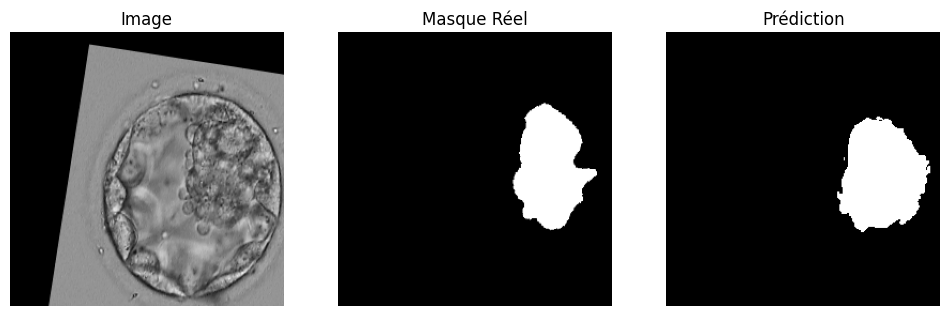

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


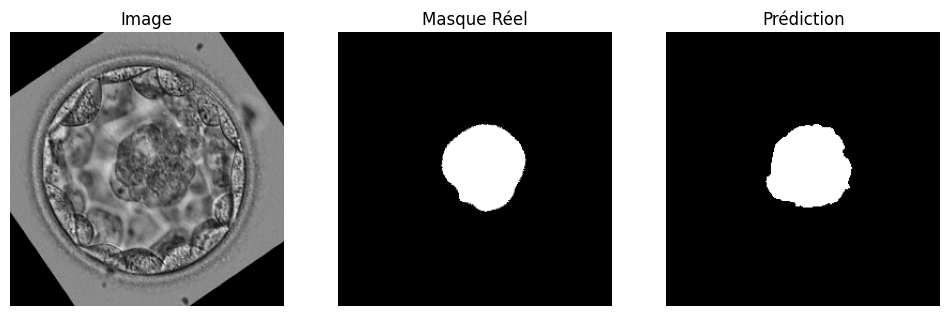

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


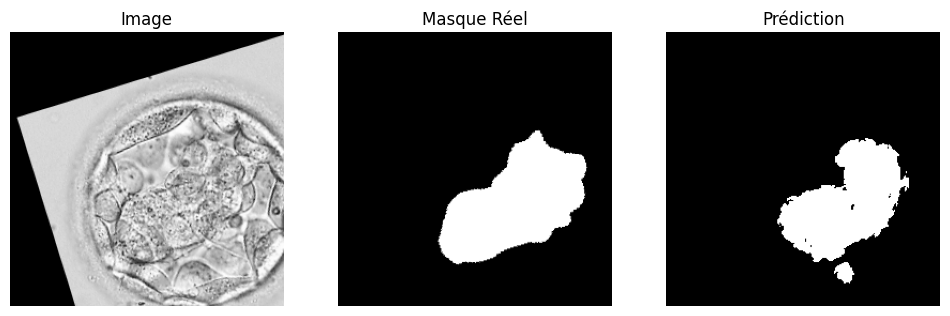

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


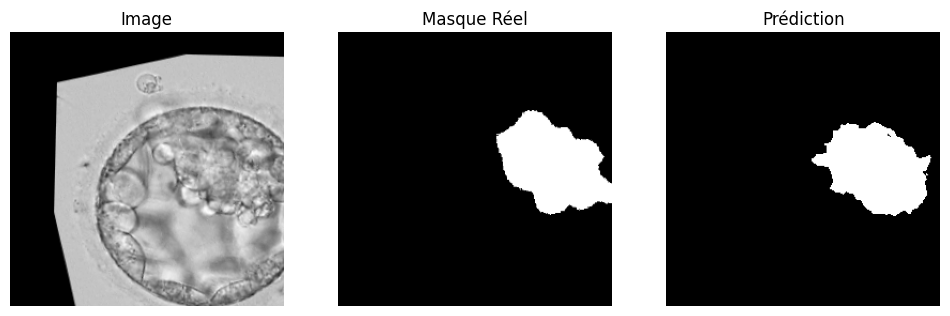

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


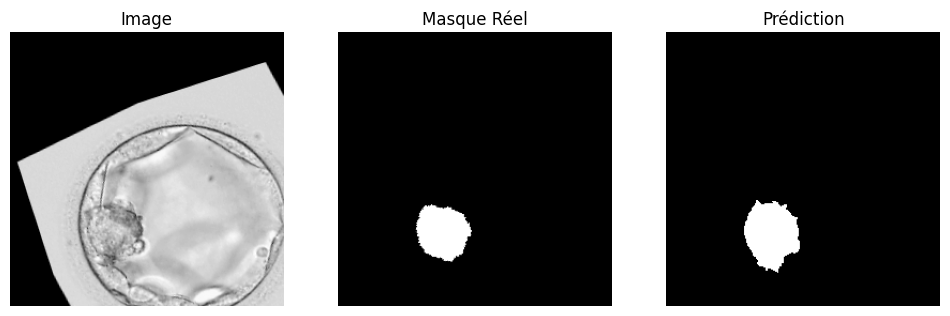

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(i):
    image = X_test[i]
    true_mask = Y_test[i]

    # Appliquer le seuil de 0.5 pour la prédiction
    pred_mask = modelicm.predict(image[np.newaxis, ...])[0]
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)  # Seuil de 0.5

    plt.figure(figsize=(12, 4))

    # Image d'entrée
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Image')
    plt.axis('off')

    # Masque réel
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title('Masque Réel')
    plt.axis('off')

    # Prédiction avec le seuil
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
    plt.title('Prédiction')
    plt.axis('off')

    plt.show()
for i in range (5):
  show_prediction(i)


In [ ]:
modelicm.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - dice_metric: 0.7625 - iou_metric: 0.6539 - loss: 0.2375


[0.23569948971271515, 0.7641276717185974, 0.6556247472763062]

In [48]:
#code il channel att kifmadecribed fil paper normalement

def channel_attention(x, ratio=2):
    channel = x.shape[-1]
    shared_dense_one = layers.Dense(channel//ratio , activation='relu', kernel_initializer='he_normal')
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal')

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    out = layers.Add()([avg_out, max_out])
    out = layers.Activation('sigmoid')(out)
    out=layers.Multiply()([x, out])
    out = layers.Add()([out, x])
    return out


In [49]:
#decoder zidto il att bich nintegrih fil model
def decoder_blockch(x,skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x=channel_attention(x)
    return x


In [11]:
def build_unetch(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blockch(b1, s4, 128)
    d2 = decoder_blockch(d1, s3, 64)
    d3 = decoder_blockch(d2, s2, 32)
    d4 = decoder_blockch(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]
modelicm_ch = build_unetch(input_shape)
modelicm_ch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [ ]:
history = modelicm_ch.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 793ms/step - dice_metric: 0.1559 - iou_metric: 0.0872 - loss: 0.8441 - val_dice_metric: 0.1459 - val_iou_metric: 0.0820 - val_loss: 0.8527 - learning_rate: 1.0000e-04
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - dice_metric: 0.2318 - iou_metric: 0.1436 - loss: 0.7682 - val_dice_metric: 0.1510 - val_iou_metric: 0.0915 - val_loss: 0.8471 - learning_rate: 1.0000e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - dice_metric: 0.2962 - iou_metric: 0.2266 - loss: 0.7039 - val_dice_metric: 0.1930 - val_iou_metric: 0.1192 - val_loss: 0.8052 - learning_rate: 1.0000e-04
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - dice_metric: 0.3224 - iou_metric: 0.2962 - loss: 0.6776 - val_dice_metric: 0.1925 - val_iou_metric: 0.1435 - val_loss: 0.8043 - learning_rate: 1.0000e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - dice_metric: 0.3588 - iou_metric: 0.4009 - loss: 0.6413 - val_dice_metric: 0.2151 - val_iou_metric: 0.1811 -

In [ ]:
modelicm_ch.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - dice_metric: 0.8218 - iou_metric: 0.7384 - loss: 0.1784


[0.17842544615268707, 0.8218652009963989, 0.7374995946884155]

In [12]:
#behy lahnee 3ana code il attention mta3 spatial il fih dual pathway (fih fonction mta3 sinle âthway 5ater nist7a9ouha)

import tensorflow as tf
from tensorflow.keras import layers

def dual_pathway_spatial_attention(x_l, x_h, out_channels):
    """
    Dual-pathway AG block: spatial attention for decoder stage s.

    Args:
        x_h: high-level feature map (upsampled from decoder)
        x_l: low-level feature map (from encoder)
        out_channels: number of output channels after ΦC conv (e.g., 64, 32, 16)

    Returns:
        Calibrated feature map after dual-pathway attention.
    """
    def single_path_attention(x_l, x_h):
        # Reduce channel dimensions
        theta_x_l = layers.Conv2D(out_channels, (1, 1), padding='same')(x_l)
        phi_x_h = layers.Conv2D(out_channels, (1, 1), padding='same')(x_h)

        # Combine and activate
        add = layers.Add()([theta_x_l, phi_x_h])
        act = layers.Activation('relu')(add)

        # Attention map α ∈ [0, 1]
        alpha = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act)
        return layers.Multiply()([x_l, alpha])  # x_l · α

    # First AG pathway
    ag1 = single_path_attention(x_l, x_h)

    # Second AG pathway (can be made slightly different if needed)
    ag2 = single_path_attention(x_l, x_h)

    # Concatenate both pathways (along channel axis)
    concat = layers.Concatenate(axis=-1)([ag1, ag2])

    # Apply ΦC (1x1 conv + BN + ReLU)
    conv = layers.Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(concat)
    bn = layers.BatchNormalization()(conv)
    out = layers.Activation('relu')(bn)

    return out


In [13]:
#kifkif lahne decoder bil attention mta3 dual pathway
def decoder_blocksp(x,skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    xatt=dual_pathway_spatial_attention(skip,x,filters)
    x = layers.Concatenate(axis=-1)([x,xatt])
    x = conv_block(x, filters)
    return x


In [14]:
def build_unetsp(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blocksp(b1, s4, 128)
    d2 = decoder_blocksp(d1, s3, 64)
    d3 = decoder_blocksp(d2, s2, 32)
    d4 = decoder_blocksp(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]
modelicm_sp = build_unetsp(input_shape)
modelicm_sp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [ ]:
history = modelicm_sp.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - dice_metric: 0.1461 - iou_metric: 0.0863 - loss: 0.8539 - val_dice_metric: 0.1415 - val_iou_metric: 0.0804 - val_loss: 0.8573 - learning_rate: 1.0000e-04
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - dice_metric: 0.2009 - iou_metric: 0.1333 - loss: 0.7992 - val_dice_metric: 0.1406 - val_iou_metric: 0.0754 - val_loss: 0.8581 - learning_rate: 1.0000e-04
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - dice_metric: 0.2289 - iou_metric: 0.1886 - loss: 0.7712 - val_dice_metric: 0.1770 - val_iou_metric: 0.1306 - val_loss: 0.8214 - learning_rate: 1.0000e-04
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - dice_metric: 0.2508 - iou_metric: 0.2555 - loss: 0.7492 - val_dice_metric: 0.1961 - val_iou_metric: 0.1538 - val_loss: 0.8026 - learning_rate: 1.0000e-04
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - dice_metric: 0.2681 - iou_metric: 0.3245 - loss: 0.7320 - val_dice_metric: 0.2034 - val_iou_metric: 0.2045 - 

In [ ]:
modelicm_sp.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - dice_metric: 0.7330 - iou_metric: 0.7204 - loss: 0.2674


[0.26475390791893005, 0.7364014387130737, 0.7232277989387512]

In [ ]:
! pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 18.8 MB/s eta 0:00:00


In [15]:
#behy hethi normalement kont newi ni5dim baha il assd (il metrique thenya ily fil paper) ama jetni chwaya problems faha donc tafita w rakazt m3 il models w il attentions , no need truniwha!
import tensorflow as tf
import numpy as np
import SimpleITK as sitk

def get_maps(binary_seg):
    dist_map = sitk.Abs(sitk.SignedMaurerDistanceMap(binary_seg,
                                                     squaredDistance=False,
                                                     useImageSpacing=True))
    surface_map = sitk.LabelContour(binary_seg)
    return dist_map, surface_map

def compute_assd_numpy(y_pred_np, y_true_np):
    y_pred_np = (y_pred_np > 0.5).astype(np.uint8)
    y_true_np = (y_true_np > 0.5).astype(np.uint8)

    pred_img = sitk.GetImageFromArray(y_pred_np)
    gt_img = sitk.GetImageFromArray(y_true_np)

    pred_dist, pred_surf = get_maps(pred_img)
    gt_dist, gt_surf = get_maps(gt_img)

    pred2gt = sitk.GetArrayFromImage(gt_dist) * sitk.GetArrayFromImage(pred_surf)
    gt2pred = sitk.GetArrayFromImage(pred_dist) * sitk.GetArrayFromImage(gt_surf)

    pred_dists = pred2gt[sitk.GetArrayFromImage(pred_surf) == 1]
    gt_dists = gt2pred[sitk.GetArrayFromImage(gt_surf) == 1]

    if len(pred_dists) == 0 and len(gt_dists) == 0:
        return 0.0
    elif len(pred_dists) == 0 or len(gt_dists) == 0:
        return np.inf

    assd = np.mean(np.concatenate([pred_dists, gt_dists]))
    return assd

@tf.function
def assd_metric(y_true, y_pred):
    return tf.numpy_function(compute_assd_numpy, [y_pred, y_true], tf.float64)


ModuleNotFoundError: No module named 'SimpleITK'

In [16]:
#hethi code il spatial attention ily taamil kif il transformer , kifmadecribed fil paper
from tensorflow.keras import layers, backend as K
import tensorflow as tf

def SA1_non_local_attention(x, inter_channels=64):
    input_channels = x.shape[-1]
    H, W = x.shape[1], x.shape[2]  # Capture symbolic H and W

    # Step 1: Reduce channels
    x_0   = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_00  = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_000 = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)

    # Step 2: Flatten (B, H, W, C) → (B, H*W, C)
    def reshape_for_attention(y):
        return tf.reshape(y, (tf.shape(y)[0], -1, inter_channels))  # (B, HW, C)

    x_theta = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_0)
    x_phi   = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_00)
    x_g     = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_000)

    # Step 3: Attention weights
    attention_scores = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1], transpose_b=True),
        output_shape=(None, None, None)
    )([x_theta, x_phi])

    attention = layers.Activation('softmax')(attention_scores)

    # Step 4: Apply attention: α · g
    x_att = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1]),
        output_shape=(None, None, inter_channels)
    )([attention, x_g])

    # Step 5: Reshape back to (B, H, W, C)
    def reshape_back(y):
        return tf.reshape(y, (-1, H, W, inter_channels))

    x_att_reshaped = layers.Lambda(reshape_back, output_shape=(H, W, inter_channels))(x_att)

    # Step 6: Project back to input channels
    x_out = layers.Conv2D(input_channels, (1, 1), padding='same', use_bias=False)(x_att_reshaped)
    x_out = layers.BatchNormalization()(x_out)

    return layers.Add()([x_out, x])


In [17]:
def decoder_blocknlb(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = SA1_non_local_attention(x)
    x = conv_block(x, filters)
    return x


In [18]:
def build_unetnlb(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blocknlb(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [19]:
input_shape = X_train.shape[1:]
modelicm_nlb = build_unetnlb(input_shape)
modelicm_nlb.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [ ]:
history = modelicm_nlb.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
)

Epoch 1/200


KeyboardInterrupt: 

In [ ]:
modelicm_nlb.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - dice_metric: 0.8066 - iou_metric: 0.7232 - loss: 0.1935


[0.1911545693874359, 0.8092865943908691, 0.7262148857116699]

In [20]:
#behy lahnee rakabt il spatial attentions fi blayshom (sa1 non local block w il ba9i dual pathway)
def build_unetspt(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blocknlb(b1, s4, 128)
    d2 = decoder_blocksp(d1, s3, 64)
    d3 = decoder_blocksp(d2, s2, 32)
    d4 = decoder_blocksp(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [21]:
input_shape = X_train.shape[1:]
modelicm_spt = build_unetspt(input_shape)
modelicm_spt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [ ]:
history = modelicm_spt.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - dice_metric: 0.1426 - iou_metric: 0.0947 - loss: 0.8574 - val_dice_metric: 0.1393 - val_iou_metric: 0.0368 - val_loss: 0.8594 - learning_rate: 1.0000e-04
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - dice_metric: 0.1996 - iou_metric: 0.1556 - loss: 0.8004 - val_dice_metric: 0.1550 - val_iou_metric: 0.0801 - val_loss: 0.8438 - learning_rate: 1.0000e-04
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - dice_metric: 0.2463 - iou_metric: 0.2305 - loss: 0.7537 - val_dice_metric: 0.1549 - val_iou_metric: 0.0835 - val_loss: 0.8436 - learning_rate: 1.0000e-04
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - dice_metric: 0.2847 - iou_metric: 0.3648 - loss: 0.7153 - val_dice_metric: 0.1554 - val_iou_metric: 0.0838 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - dice_metric: 0.3076 - iou_metric: 0.4935 - loss: 0.6924 - val_dice_metric: 0.1649 - val_iou_metric: 0.0917 - v

In [ ]:
modelicm_spt.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_metric: 0.8330 - iou_metric: 0.7421 - loss: 0.1674


[0.16776899993419647, 0.8334372639656067, 0.7424226999282837]

In [22]:
#decoder hatha rakabt fih il spatial mta3 dual pathway w il channel attention
def decoder_blockspc(x,skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    xatt=dual_pathway_spatial_attention(skip,x,filters)
    x = layers.Concatenate(axis=-1)([x, xatt])
    x = conv_block(x, filters)
    x=channel_attention(x)
    return x


In [23]:
#decoder hatha bil non local block spatial attention w il channel attention
def decoder_blocknlbc(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = SA1_non_local_attention(x)
    x = conv_block(x, filters)
    x=channel_attention(x)
    return x


In [24]:
def build_unetsptc(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blocknlbc(b1, s4, 128) #hatha il non local block mouch kif 5weto(spatial mouch kifkif ala hathik fama nlbc w spc)
    d2 = decoder_blockspc(d1, s3, 64)
    d3 = decoder_blockspc(d2, s2, 32)
    d4 = decoder_blockspc(d3, s1, 16)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [25]:
input_shape = X_train.shape[1:]
modelicm_sptc = build_unetsptc(input_shape)
modelicm_sptc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [ ]:
history = modelicm_sptc.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - dice_metric: 0.1473 - iou_metric: 0.0782 - loss: 0.8527 - val_dice_metric: 0.1436 - val_iou_metric: 0.0824 - val_loss: 0.8551 - learning_rate: 1.0000e-04
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - dice_metric: 0.1919 - iou_metric: 0.1089 - loss: 0.8081 - val_dice_metric: 0.1414 - val_iou_metric: 0.0817 - val_loss: 0.8573 - learning_rate: 1.0000e-04
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - dice_metric: 0.2499 - iou_metric: 0.1802 - loss: 0.7501 - val_dice_metric: 0.1378 - val_iou_metric: 0.0621 - val_loss: 0.8609 - learning_rate: 1.0000e-04
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - dice_metric: 0.2967 - iou_metric: 0.2387 - loss: 0.7033 - val_dice_metric: 0.1432 - val_iou_metric: 0.0587 - val_loss: 0.8549 - learning_rate: 1.0000e-04
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - dice_metric: 0.3276 - iou_metric: 0.3179 - loss: 0.6724 - val_dice_metric: 0.1693 - val_iou_metric: 0.1282 -

In [ ]:
modelicm_sptc.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - dice_metric: 0.8331 - iou_metric: 0.7356 - loss: 0.1669


[0.1696401983499527, 0.8303278088569641, 0.7310193181037903]

In [39]:
#lahne il scale attnetion logic kif il paper...
def scale_attention_module(features):
    """
    Paper-faithful Scale Attention Module (CA-Net) with symbolic shape fix.
    Args:
        features: list of decoder feature maps from 4 different scales (d1 to d4)
    Returns:
        Final enhanced feature map (B, H, W, 4)
    """
    H, W = features[3].shape[1], features[3].shape[2]  # symbolic-safe shape

    # 1. Resize all feature maps to same shape
    resized = [layers.Resizing(H, W, interpolation='bilinear')(f) for f in features]

    # 2. Compress to 1 channel per scale
    compressed = [layers.Conv2D(1, (1, 1), padding='same')(f) for f in resized]

    # 3. Concatenate → F̂ (B, H, W, 4)
    F_hat = layers.Concatenate(axis=-1)(compressed)

    # 4. Scale-wise attention γ
    gap = layers.GlobalAveragePooling2D()(F_hat)
    gmp = layers.GlobalMaxPooling2D()(F_hat)
    gap = layers.Reshape((1, 1, 4))(gap)
    gmp = layers.Reshape((1, 1, 4))(gmp)

    gamma = layers.Add()([gap, gmp])
    gamma = layers.Activation('sigmoid')(gamma)  # (B, 1, 1, 4)

    F_gamma = layers.Multiply()([F_hat, gamma])  # (B, H, W, 4)

    # 5. Pixel-wise scale attention γ*
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(F_gamma)
    gamma_star = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(x)

    # 6. Final residual + fused output
    out = layers.Add()([
        layers.Multiply()([F_hat, gamma, gamma_star]),
        layers.Multiply()([F_hat, gamma]),
        F_hat
    ])

    return out


In [40]:
def build_unetsc(input_shape):
    inputs = tf.keras.Input(input_shape)

    # ---- Encoder
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    # ---- Bottleneck
    b1 = conv_block(p4, 256)

    # ---- Decoder
    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    # ---- Scale Attention Module
    la_output = scale_attention_module([d1, d2, d3, d4])  # returns enhanced feature map    lahneee just zidta il scale attention w il ba9i unet aadi

    # ---- Final Output
    output = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(la_output)

    return Model(inputs, output)


In [41]:
input_shape = X_train.shape[1:]
modelicm_sc = build_unetsc(input_shape)
modelicm_sc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [42]:
history = modelicm_sc.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - dice_metric: 0.2176 - iou_metric: 0.1307 - loss: 0.7824 - val_dice_metric: 0.1772 - val_iou_metric: 0.1092 - val_loss: 0.8211 - learning_rate: 1.0000e-04
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - dice_metric: 0.4301 - iou_metric: 0.2960 - loss: 0.5700 - val_dice_metric: 0.1473 - val_iou_metric: 0.0667 - val_loss: 0.8513 - learning_rate: 1.0000e-04
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - dice_metric: 0.6559 - iou_metric: 0.5092 - loss: 0.3441 - val_dice_metric: 0.1927 - val_iou_metric: 0.1635 - val_loss: 0.8055 - learning_rate: 1.0000e-04
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - dice_metric: 0.7097 - iou_metric: 0.5608 - loss: 0.2903 - val_dice_metric: 0.2722 - val_iou_metric: 0.1979 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - dice_metric: 0.7440 - iou_metric: 0.6024 - loss: 0.2560 - val_dice_metric: 0.2310 - val_iou_metric: 0.1531 

In [43]:
modelicm_sc.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dice_metric: 0.8239 - iou_metric: 0.7019 - loss: 0.1762


[0.17817936837673187, 0.8221490979194641, 0.6993597745895386]

In [44]:
# il lobza kemla :))))
def build_unettotale(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_blocknlbc(b1, s4, 128)
    d2 = decoder_blockspc(d1, s3, 64)
    d3 = decoder_blockspc(d2, s2, 32)
    d4 = decoder_blockspc(d3, s1, 16)
    la_output = scale_attention_module([d1, d2, d3, d4])  # returns enhanced feature map

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [45]:
input_shape = X_train.shape[1:]
modelicm_totale = build_unettotale(input_shape)
modelicm_totale.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_metric,iou_metric])

In [46]:
history = modelicm_totale.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - dice_metric: 0.1487 - iou_metric: 0.0820 - loss: 0.8513 - val_dice_metric: 0.1426 - val_iou_metric: 0.0814 - val_loss: 0.8561 - learning_rate: 1.0000e-04
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - dice_metric: 0.1771 - iou_metric: 0.1048 - loss: 0.8229 - val_dice_metric: 0.1496 - val_iou_metric: 0.0900 - val_loss: 0.8487 - learning_rate: 1.0000e-04
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - dice_metric: 0.2334 - iou_metric: 0.1558 - loss: 0.7667 - val_dice_metric: 0.1558 - val_iou_metric: 0.0824 - val_loss: 0.8426 - learning_rate: 1.0000e-04
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - dice_metric: 0.2925 - iou_metric: 0.2681 - loss: 0.7075 - val_dice_metric: 0.1641 - val_iou_metric: 0.0864 - val_loss: 0.8341 - learning_rate: 1.0000e-04
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - dice_metric: 0.3408 - iou_metric: 0.4352 - loss: 0.6592 - val_dice_metric: 0.2039 - val_iou_metric: 0.1266 - 

In [47]:
modelicm_totale.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - dice_metric: 0.8377 - iou_metric: 0.7394 - loss: 0.1624


[0.16023856401443481, 0.8401926159858704, 0.7428738474845886]

In [ ]:
# donc chabeb ken chitjarbo , aawdo runiw il codes ken t7ibo tchoufo il performance 5ater fama chwaya changementet (tsir randomly...) wala jarbo 3al zp w il te kifmat7ibo:)